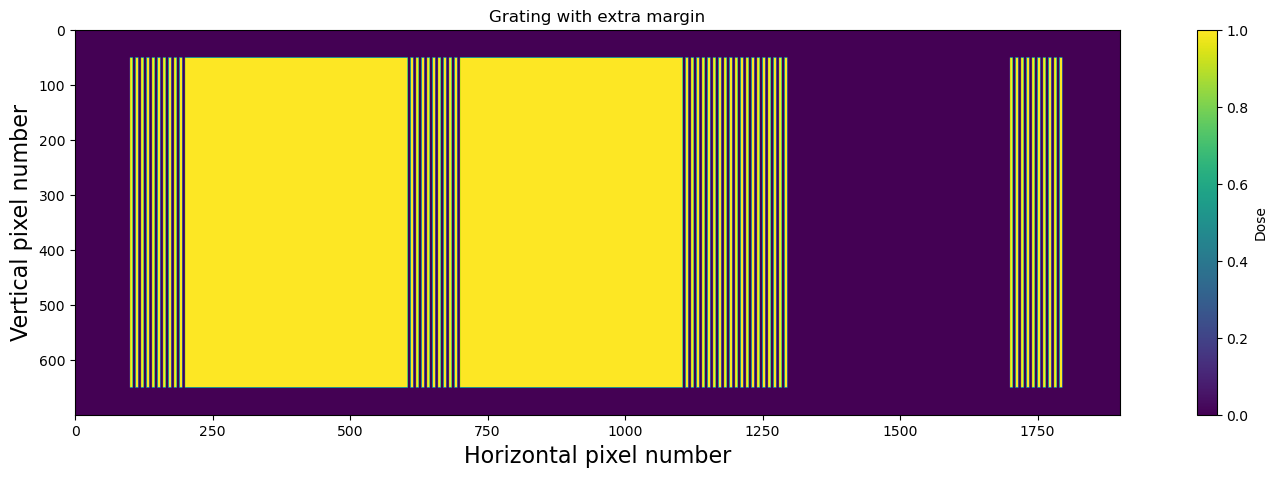

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.transform import resize 

eta = 0.5 #@50 keV on si
sigma_b = 6 #@50 keV on si

RT = 1 # Resist Threshold 
#ED =  #Effective Dose

#PB = (eta/sigma_b**2) * np.exp(-np.abs(r**2)/sigma_b**2)

min_pix_size = int(25) #nanometers 
width = int(42500) #nanometers 
height = int(15000) #nanometers 
pix_width = int(width/min_pix_size)
pix_height = int(height/min_pix_size)

y = np.linspace(0,int(width),int(pix_width)) #Radius
x = np.linspace(0,int(height),int(pix_height))


dose_map = np.zeros((pix_height,pix_width))
grating_width = 250
pix_grating_width = int(grating_width/min_pix_size)


left_grating = np.zeros((pix_height, pix_grating_width*20))


for i in range(dose_map.shape[1]):
    for j in range(dose_map.shape[0]):
        if i < 100:
            if i%10 < 5:
                dose_map[j,i] = 1
                
        if 99.5 < i < 500:
            dose_map[j,i] = 1

        if 499.5 < i < 600:
            if i%10 < 5:
                dose_map[j,i] = 1

        if 599.5 < i < 1000:
            dose_map[j,i] = 1

        if 999.5 < i < 1200:
            if i%10 < 5:
                dose_map[j,i] = 1

        if 1199.5 < i < 1600:
            dose_map[j,i] = 0

        if 1599.5 < i < 1700:
            if i%10 < 5:
                dose_map[j,i] = 1
    


# Desired padding on each side
pad_left = 100
pad_right = 100
pad_top = 50
pad_bottom = 50


# Original dimensions
orig_height, orig_width = dose_map.shape

# New array with extra rows/columns for padding
new_height = orig_height + pad_top + pad_bottom
new_width  = orig_width  + pad_left + pad_right

dose_map_padded = np.zeros((new_height, new_width))

# Copy the original dose_map into the padded array
dose_map_padded[pad_top:pad_top+orig_height, pad_left:pad_left+orig_width] = dose_map

dose_map = dose_map_padded

plt.figure(figsize=(20, 5))
plt.imshow(dose_map, cmap='viridis')
plt.colorbar(label='Dose')
plt.xlabel('Horizontal pixel number', fontsize=16)
plt.ylabel('Vertical pixel number', fontsize=16)
plt.title('Grating with extra margin')
plt.show()


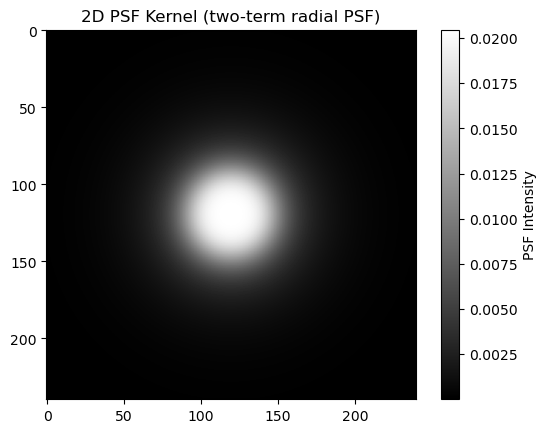

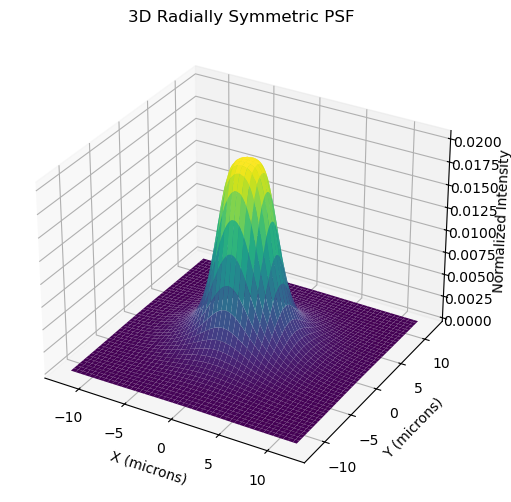

In [6]:
from scipy.ndimage import convolve
from scipy.signal import convolve2d
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting

##############################################################################
# 1) Define parameters for the new PSF (in microns)
##############################################################################
nu     = 3.48    # example value, adjust as needed
gamma  = 3.07    # microns



sigma  = 4.45    # dimensionless exponent
eta    = 0.5    # dimensionless (same as your original)
beta   = 6.0    # microns

##############################################################################
# 2) Grid setup for plotting a 2D kernel
##############################################################################
grid_size = (500, 500)  # e.g. 500x500 pixels
x_extent = 50.0         # total microns spanned in the x-direction

pixel_per_micron = grid_size[1] / x_extent

##############################################################################
# 3) We'll pick a kernel size in pixels that's "large enough"
##############################################################################
kernel_size = int(4 * max(gamma, beta) * pixel_per_micron)
# Make sure kernel_size is odd or at least > 0
kernel_size = max(kernel_size, 31)  # ensure at least 31x31

# Build coordinate axes for the kernel (pixel coordinates, centered at 0)
x = np.linspace(-kernel_size/2, kernel_size/2, kernel_size)
y = np.linspace(-kernel_size/2, kernel_size/2, kernel_size)
X, Y = np.meshgrid(x, y)

##############################################################################
# 4) Convert pixel units -> microns and compute radial distance r
##############################################################################
# Each pixel step = 1/pixel_per_micron microns
X_um = X / pixel_per_micron
Y_um = Y / pixel_per_micron
r_um = np.sqrt(X_um**2 + Y_um**2)

##############################################################################
# 5) Define the new PSF function
##############################################################################
def psf_two_term(r, nu, gamma, sigma, eta, beta):
    """
    Two-term radial point-spread function:
      Psi(r) = [1 / ( pi * (1 + eta) )] * [ nu^-2 / (1 + (r/gamma)^sigma ) + (eta / beta^2) * exp( - (r/beta)^2 ) ]
    """
    prefactor = 1.0 / (np.pi * (1.0 + eta))
    term1 = nu**(-2) / (1.0 + (r / gamma)**sigma)
    term2 = (eta / beta**2) * np.exp(- (r / beta)**2)
    return prefactor * (term1 + term2)

##############################################################################
# 6) Evaluate the PSF on our 2D grid
##############################################################################
PSF_kernel = psf_two_term(r_um, nu, gamma, sigma, eta, beta)


##############################################################################
# 8) Plot the 2D kernel
##############################################################################
plt.figure()
plt.imshow(PSF_kernel, cmap='gray')
plt.colorbar(label='PSF Intensity')
plt.title('2D PSF Kernel (two-term radial PSF)')
plt.show()

##############################################################################
# 9) 3D surface plot for visualization
##############################################################################
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X_um, Y_um, PSF_kernel, cmap='viridis', edgecolor='none')
ax.set_title('3D Radially Symmetric PSF')
ax.set_xlabel('X (microns)')
ax.set_ylabel('Y (microns)')
ax.set_zlabel('Normalized Intensity')
plt.show()


<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:49: SyntaxWarning: invalid escape sequence '\m'
/var/folders/sm/89rv8yy96bscxt0tyvc5xpjm0000gn/T/ipykernel_25618/2778317670.py:49: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('Position $(\mu$m)')


(700, 1900)
(240, 240)


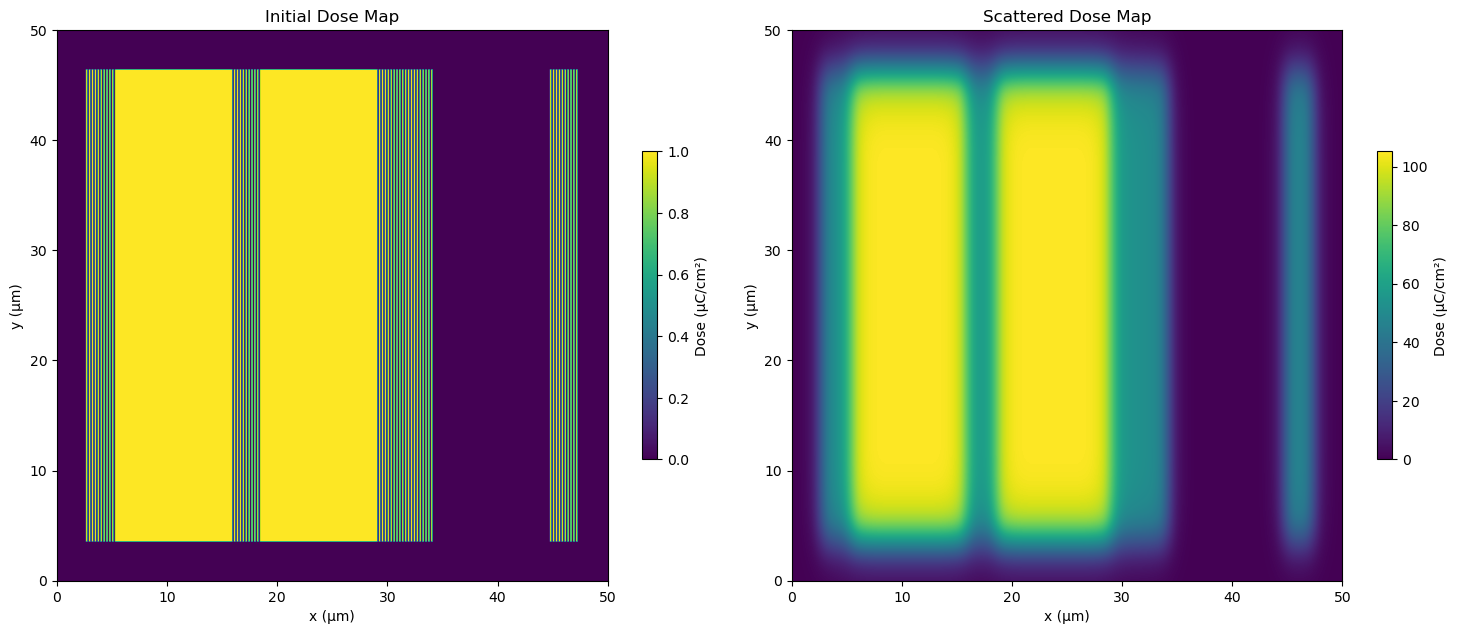

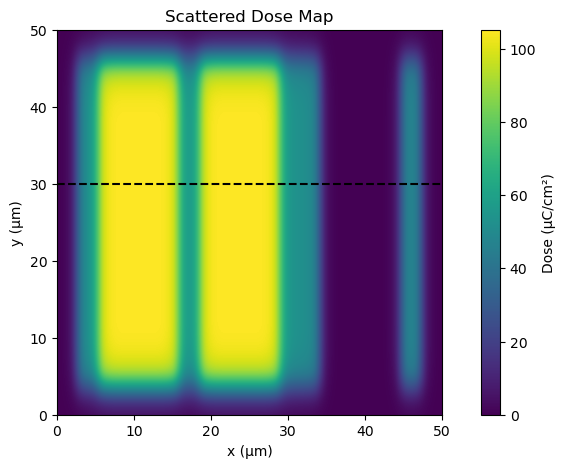

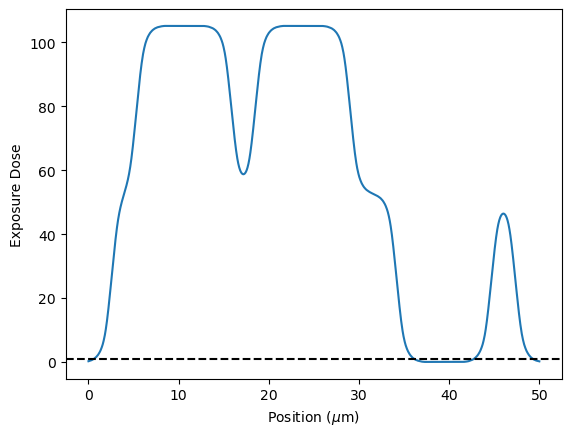

In [14]:
from scipy.signal import convolve2d

dose_with_scattering = convolve2d(dose_map, PSF_kernel, mode='same')



In [2]:


# Create a figure with 3 subplots arranged in a row
fig, axes = plt.subplots(1, 2, figsize=(15, 8) ) # 1 row, 2 columns

# Plot the first figure
axes[0].imshow(dose_map, cmap='viridis')
axes[0].set_title('Initial Dose Map')
#axes[0].set_xlabel('x (µm)')
#axes[0].set_ylabel('y (µm)')
axes[0].set_xlabel('x pixel number ')
axes[0].set_ylabel('y pixel number')
cbar1 = fig.colorbar(axes[0].images[0], ax=axes[0], orientation='vertical', shrink=0.4)
cbar1.set_label('Dose (μC/cm²)')

# Plot the second figure
axes[1].imshow(dose_with_scattering, cmap='viridis')
axes[1].set_title('Scattered Dose Map')
#axes[1].set_xlabel('x (µm)')
#axes[1].set_ylabel('y (µm)')
axes[1].set_xlabel('x pixel number ')
axes[1].set_ylabel('y pixel number')
cbar2 = fig.colorbar(axes[1].images[0], ax=axes[1], orientation='vertical', shrink=0.4)
cbar2.set_label('Dose (μC/cm²)')


# Adjust layout for better spacing
plt.tight_layout()
plt.show()





dose_slice = dose_with_scattering[300,:]
x_1d = np.linspace(0, 50, len(dose_slice))

plt.plot(x_1d,dose_slice)
plt.axhline(y = 1.0, color = 'black', linestyle = '--') 
plt.xlabel('Position $(\mu$m)')
plt.ylabel('Exposure Dose')
plt.savefig('1D Dose.png')

<>:38: SyntaxWarning: invalid escape sequence '\m'
<>:38: SyntaxWarning: invalid escape sequence '\m'
/var/folders/sm/89rv8yy96bscxt0tyvc5xpjm0000gn/T/ipykernel_26046/1050817269.py:38: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('Position $(\mu$m)')
/var/folders/sm/89rv8yy96bscxt0tyvc5xpjm0000gn/T/ipykernel_26046/1050817269.py:38: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('Position $(\mu$m)')


NameError: name 'plt' is not defined

In [5]:

mask = np.where(dose_map == 0)


iterations = 5
for j in range(iterations):

    #Determining the scattered dose 
    Convolution = convolve2d(dose_map, PSF_kernel, mode='same')
    
    #Correcting the dose using formula from Watson paper 
    dose_map = 2 * (d_0 - Convolution)
    
    dose_map[mask] = 0
    
    print(j)


NameError: name 'PSF_kernel' is not defined

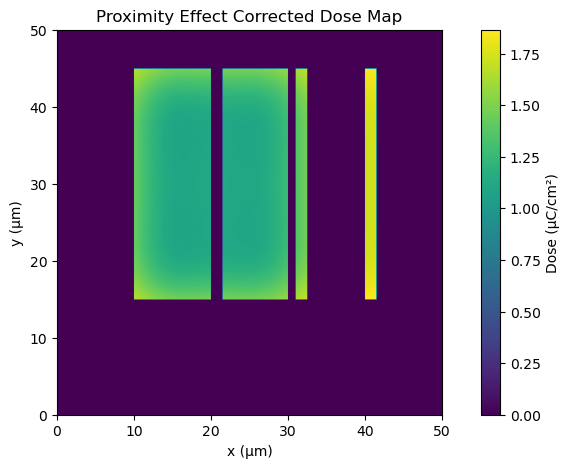

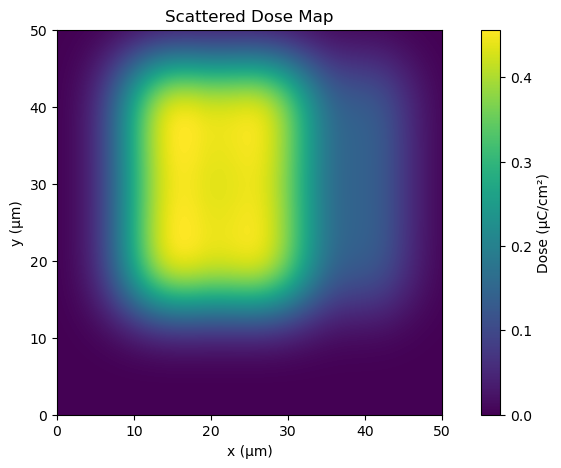

In [65]:
Scattered_dose = Convolution

plt.figure(figsize=(10, 5))
plt.imshow(dose_map, cmap='viridis', extent=[0, x_extent, 0, 50])
plt.colorbar(label='Dose (μC/cm²)')
plt.xlabel('x (µm)')
plt.ylabel('y (µm)')
plt.title('Proximity Effect Corrected Dose Map')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(Scattered_dose, cmap='viridis', extent=[0, x_extent, 0, 50])
plt.colorbar(label='Dose (μC/cm²)')
plt.xlabel('x (µm)')
plt.ylabel('y (µm)')
plt.title('Scattered Dose Map')
plt.show()

<>:19: SyntaxWarning: invalid escape sequence '\m'
<>:19: SyntaxWarning: invalid escape sequence '\m'
/var/folders/sm/89rv8yy96bscxt0tyvc5xpjm0000gn/T/ipykernel_22958/1797377213.py:19: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('Position $(\mu$m)')


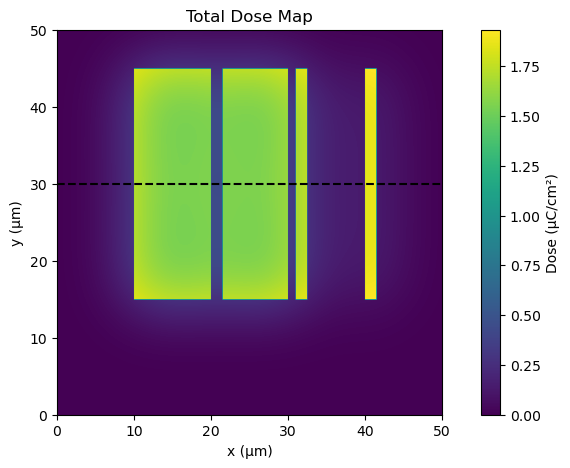

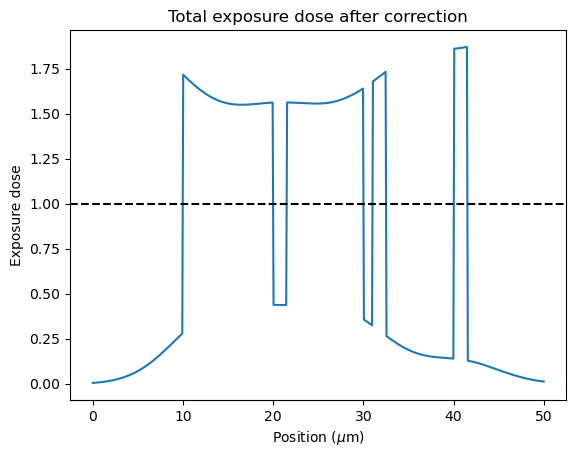

In [67]:
Total_dose = dose_map + Scattered_dose

a = 200
Total_dose_slice = Total_dose[a,:]
x_1d = np.linspace(0, 50, len(dose_slice))

plt.figure(figsize=(10, 5))
plt.imshow(Total_dose, cmap='viridis', extent=[0, x_extent, 0, 50])
plt.axhline(y= 30, color='black', linestyle='--', linewidth=1.5)
plt.colorbar(label='Dose (μC/cm²)')
plt.xlabel('x (µm)')
plt.ylabel('y (µm)')
plt.title('Total Dose Map')
plt.show()


plt.plot(x_1d,Total_dose_slice)
plt.axhline(y = d_0, color = 'black', linestyle = '--') 
plt.xlabel('Position $(\mu$m)')
plt.ylabel('Exposure dose')
plt.title('Total exposure dose after correction')
plt.savefig('1D Dose.png')

<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
/var/folders/sm/89rv8yy96bscxt0tyvc5xpjm0000gn/T/ipykernel_22958/2685359839.py:5: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('Position $(\mu$m)')


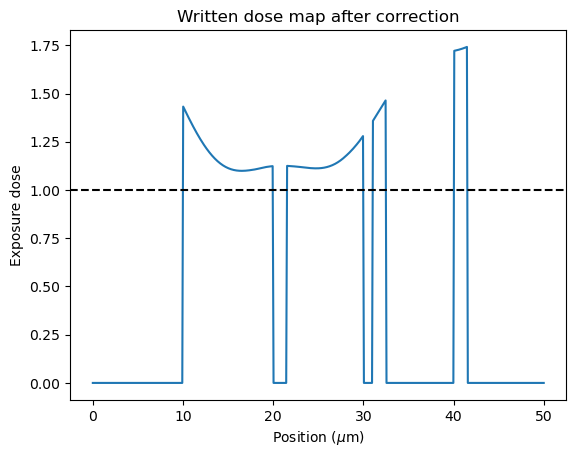

In [71]:
written_dose_slice = dose_map[a,:]

plt.plot(x_1d,written_dose_slice)
plt.axhline(y = d_0, color = 'black', linestyle = '--') 
plt.xlabel('Position $(\mu$m)')
plt.ylabel('Exposure dose')
plt.title('Written dose map after correction')
plt.savefig('1D Dose.png')